Demand Forecasting for Retail Shop

In [4]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [5]:
#2. Load dataset
df = pd.read_csv("mock_kaggle.csv")

In [7]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')

In [8]:
# Set Date as index
df.set_index('Date', inplace=True)


In [9]:
# Check first rows
print(df.head())


            Sales  Stock  Price
Date                           
2014-01-01      0   4972   1.29
2014-01-02     70   4902   1.29
2014-01-03     59   4843   1.29
2014-01-04     93   4750   1.29
2014-01-05     96   4654   1.29


Exploratory Data Analysis (EDA)

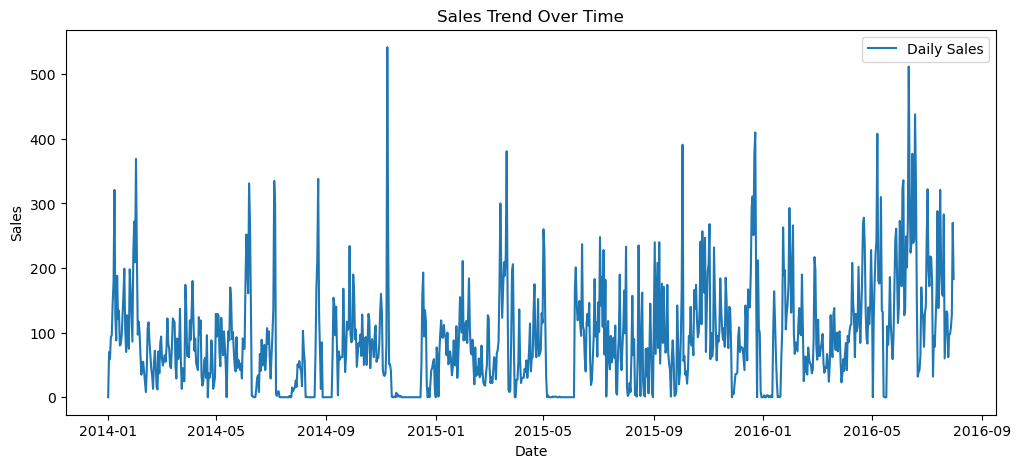

In [10]:
# Sales trend over time
plt.figure(figsize=(12,5))
plt.plot(df['Sales'], label="Daily Sales")
plt.title("Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

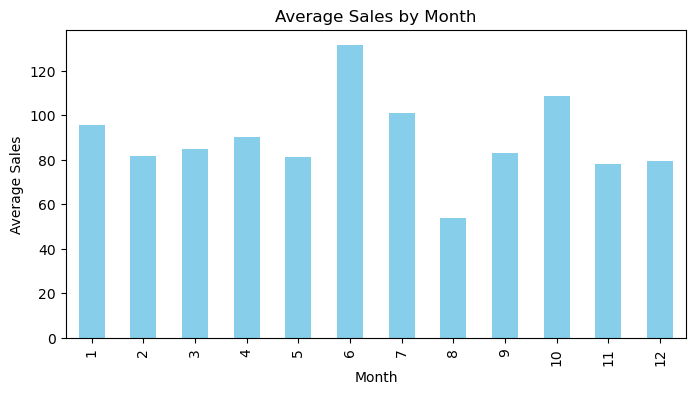

In [11]:
# Monthly seasonality (group by month)
df['Month'] = df.index.month
monthly_sales = df.groupby('Month')['Sales'].mean()

plt.figure(figsize=(8,4))
monthly_sales.plot(kind='bar', color="skyblue")
plt.title("Average Sales by Month")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.show()

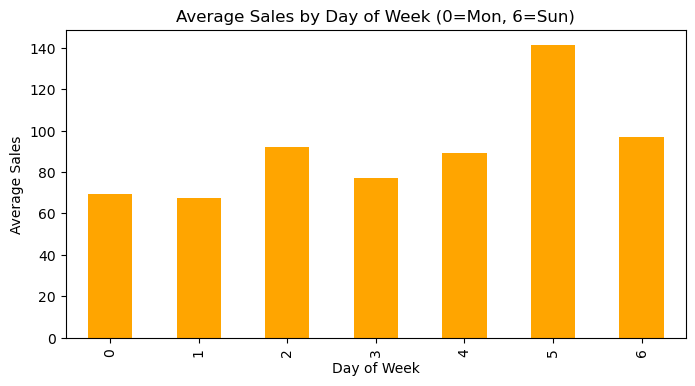

In [12]:
# Weekly seasonality (group by day of week)
df['DayOfWeek'] = df.index.dayofweek
weekly_sales = df.groupby('DayOfWeek')['Sales'].mean()

plt.figure(figsize=(8,4))
weekly_sales.plot(kind='bar', color="orange")
plt.title("Average Sales by Day of Week (0=Mon, 6=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("Average Sales")
plt.show()

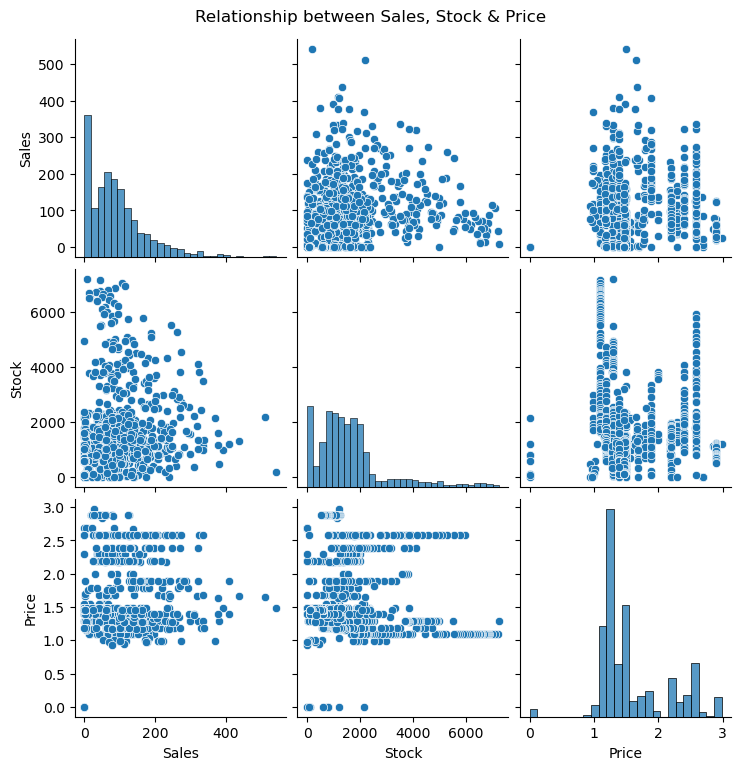

In [13]:
# Relationship between Sales, Stock, and Price
sns.pairplot(df[['Sales','Stock','Price']])
plt.suptitle("Relationship between Sales, Stock & Price", y=1.02)
plt.show()


In [14]:
corr = df[['Sales','Stock','Price']].corr()
print("Correlation Matrix:\n", corr)

Correlation Matrix:
           Sales     Stock     Price
Sales  1.000000  0.153659  0.094779
Stock  0.153659  1.000000 -0.032604
Price  0.094779 -0.032604  1.000000


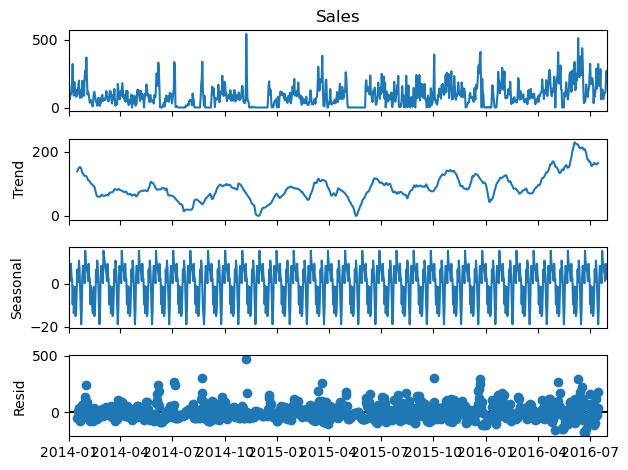

In [15]:
# Seasonal decomposition
decompose = seasonal_decompose(df['Sales'], model='additive', period=30)
decompose.plot()
plt.show()

Forecasting Model (SARIMA)

In [16]:
# Train-test split (last 90 days for testing)
train = df.iloc[:-90]
test = df.iloc[-90:]

In [19]:
# Fit SARIMA model (weekly seasonality)
model = SARIMAX(train['Sales'], order=(1,1,1), seasonal_order=(1,1,1,7))
model_fit = model.fit(disp=False)

In [24]:
pred = model_fit.get_prediction(start=len(train), end=len(train)+len(test)-1)
pred_mean = pred.predicted_mean
pred_conf = pred.conf_int()


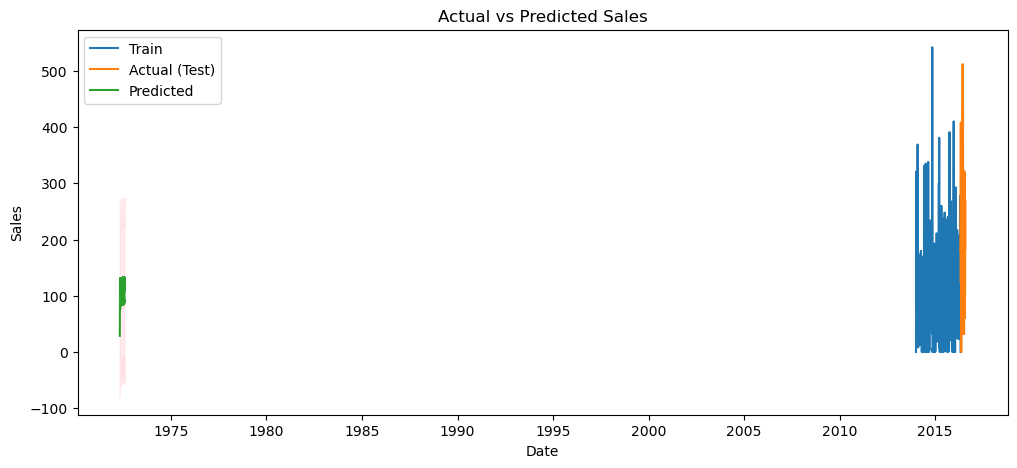

In [25]:
# Plot predictions vs actual
plt.figure(figsize=(12,5))
plt.plot(train.index, train['Sales'], label='Train')
plt.plot(test.index, test['Sales'], label='Actual (Test)')
plt.plot(pred_mean.index, pred_mean, label='Predicted')
plt.fill_between(pred_conf.index, pred_conf.iloc[:,0], pred_conf.iloc[:,1], color='pink', alpha=0.3)
plt.title("Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


Model Performance Evaluation

In [26]:
mae = mean_absolute_error(test['Sales'], pred_mean)
rmse = np.sqrt(mean_squared_error(test['Sales'], pred_mean))
mape = np.mean(np.abs((test['Sales'] - pred_mean) / test['Sales'])) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 96.00
RMSE: 123.17
MAPE: nan%


Final Forecast (Next 30 days)

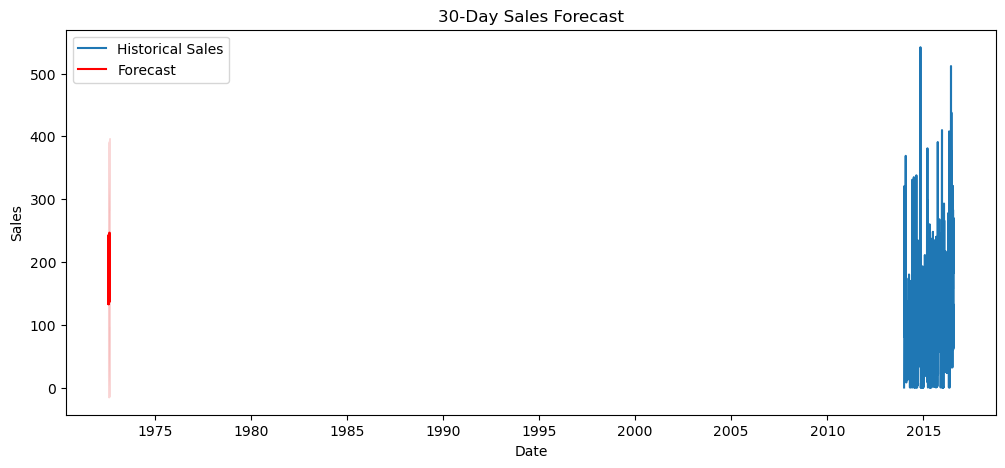

In [27]:
final_model = SARIMAX(df['Sales'], order=(1,1,1), seasonal_order=(1,1,1,7))
final_fit = final_model.fit(disp=False)

forecast = final_fit.get_forecast(steps=30)
forecast_mean = forecast.predicted_mean
forecast_conf = forecast.conf_int()

plt.figure(figsize=(12,5))
plt.plot(df.index, df['Sales'], label="Historical Sales")
plt.plot(forecast_mean.index, forecast_mean, label="Forecast", color='red')
plt.fill_between(forecast_conf.index, forecast_conf.iloc[:,0], forecast_conf.iloc[:,1], color='lightcoral', alpha=0.3)
plt.title("30-Day Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

In [28]:
# Save forecast to CSV
forecast_output = pd.DataFrame({
    "Date": forecast_mean.index,
    "Forecasted_Sales": forecast_mean.values,
    "Lower_CI": forecast_conf.iloc[:,0].values,
    "Upper_CI": forecast_conf.iloc[:,1].values
})
forecast_output.to_csv("forecast_next_30_days.csv", index=False)

print("\n✅ Forecast saved to 'forecast_next_30_days.csv'")


✅ Forecast saved to 'forecast_next_30_days.csv'
